# Initial imports

In [1]:
# Data loading
import os
from glob import glob
from pathlib import Path

# Key imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ML implementation
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

# Model evaluation
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                            recall_score, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.metrics import classification_report

# Using all labels

In [2]:
cwd = Path.cwd()
print(cwd)
prepped_data_dir = cwd / "PreppedData"

# If current path does not end in "PreppedData", move into it
if cwd.name != "PreppedData":
    if prepped_data_dir.exists():
        os.chdir(prepped_data_dir)
        print(f"Changed working directory to: {prepped_data_dir}")
    else:
        raise FileNotFoundError(f"'Annotations' directory not found at: {prepped_data_dir}")
else:
    print(f"Already in {cwd.name} directory.")

/home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/SupervisedML
Changed working directory to: /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/SupervisedML/PreppedData


In [3]:
# Load data, display relevant summary stats
n_split = 5
shuffle = True
random_state = 42

data = np.load('combined_logmed_transformed.npz')
X = data['X']
y = data['y']

print('X:')
display(X)
print('\nClass counts:', Counter(y))
print('\nX shape:', X.shape, 'y shape:', y.shape)
print('\nUnique class labels:', np.unique(y))

X:


array([[-0.00021589, -0.00021589, -0.00021589, ..., -0.00021589,
        -0.00021589, -0.00021589],
       [-0.00021602, -0.00021602, -0.00021602, ..., -0.00021602,
        -0.00021602, -0.00021602],
       [-0.00023529, -0.00023529, -0.00023529, ..., -0.00023529,
        -0.00023529, -0.00023529],
       ...,
       [-0.00026413, -0.00026413, -0.00026413, ..., -0.00018941,
        -0.00026413, -0.00026413],
       [-0.00026318, -0.00026318, -0.00026318, ..., -0.0001802 ,
        -0.00026318, -0.00026318],
       [-0.00025636, -0.00025636, -0.00025636, ..., -0.00025636,
        -0.00025636, -0.00025636]])


Class counts: Counter({np.int64(0): 1637, np.int64(1): 895, np.int64(2): 363, np.int64(4): 97, np.int64(3): 73})

X shape: (3065, 2947) y shape: (3065,)

Unique class labels: [0 1 2 3 4]


In [4]:
# Perfom stratified sampling
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    folds.append({'fold': i+1, 'train_idx': train_idx, 'val_idx': val_idx})

for fold in folds:
    train_idx = fold['train_idx']
    val_idx = fold['val_idx']
    print(len(train_idx))
    print(len(val_idx))
    
    # Check if train and val indices overlap
    overlap = set(train_idx).intersection(val_idx)
    if len(overlap) > 0:
        print(f"Warning: Overlap found in fold {fold['fold']} indices: {overlap}")
    else:
        print(f"No overlap in fold {fold['fold']} indices.")

2452
613
No overlap in fold 1 indices.
2452
613
No overlap in fold 2 indices.
2452
613
No overlap in fold 3 indices.
2452
613
No overlap in fold 4 indices.
2452
613
No overlap in fold 5 indices.


In [7]:
def xgb_cv(folds, X, y, verbose = 0,
              scoring_fns = None, use_shuffled_labels = False, use_stdscale = True,
              use_pca = True, pca_variance = 0.95, plot_cm_final = True, dummy = True):
    """
    Evaluate XGBoost (and, optionally, a Dummy Classifier) on CV folds, 
    with optional PCA.

    Key Parameters:
        - folds (list of dict): Each dict has keys 'fold', 'train_idx', 'val_idx'.
        - X (np.ndarray): Feature matrix.
        - y (np.ndarray): Label vector.

    Advanced Parameters:
        - verbose (int): Sets the level of details in the output. 
                        -> 0: Minimal details, only final results.
                        -> 1: Moderate details, per CV split performance.
                        -> 2: Maximal details, per CV split PCA results + performance.
        - use_shuffled_labels (bool): Whether to shuffle training labels. 
                                      Used as a diagnostic tool, so expect poor performance if using this.
        - use_stdscale (bool): Whether to standardise features.
        - use_pca (bool): Whether to apply PCA.
        - pca_variance (float|int): If float (0 < val ≤ 1), preserve that proportion of variance. 
                                    If int, use that many components.
        - plot_cm_final: Whether to plot the final, averaged confusion matrix, over all splits.
        - dummy (bool): Whether to include dummy classifier results.
        - scoring_fns (dict): Custom scoring functions.
                              Format: {"name": scoring_function(y_true, y_pred)}
    """
    
    if not isinstance(verbose, int):
        raise TypeError("The 'verbose' parameter must be an integer: 0, 1, or 2.")

    print('Algorithm initialising...')
    # Set default scoring functions
    if scoring_fns is None:
        scoring_fns = {
            "Accuracy": accuracy_score,
            "Balanced Accuracy": balanced_accuracy_score,
            "F1 (macro)": lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro')
        }

    # Score containers
    xgb_scores = {name: [] for name in scoring_fns}
    dummy_scores = {name: [] for name in scoring_fns} if dummy else None
    cms = []

    unique_labels = np.unique(y)
    all_y_true = []
    all_y_pred = []

    for fold in folds:
        train_idx = fold['train_idx']
        val_idx = fold['val_idx']

        X_train = X[train_idx]
        X_val = X[val_idx]
        y_train = y[train_idx]
        y_val = y[val_idx]

        if use_shuffled_labels:
            rng = np.random.default_rng(seed=fold['fold'])
            y_train = rng.permutation(y_train)

        if verbose >= 1:
            print(f"\nFold {fold['fold']}")
            print(" Train label distribution:", Counter(y_train))
            print(" Val label distribution:  ", Counter(y_val))

        if use_stdscale:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

        if use_pca:
            pca = PCA(n_components=pca_variance)
            X_train = pca.fit_transform(X_train)
            X_val = pca.transform(X_val)
            if verbose == 2:
                print(f"PCA components: {pca.n_components_}, explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")

        if verbose == 2 and X_train.shape[1] >= 2:
            plt.figure(figsize=(6, 4))
            scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='tab10', alpha=0.6)
            plt.title(f'PCA Projection (Fold {fold["fold"]})')
            plt.xlabel("PC1")
            plt.ylabel("PC2")
            plt.colorbar(scatter, label="Class")
            plt.tight_layout()
            plt.show()
            plt.close()

        # Dummy Classifier
        if dummy:
            dummy_model = DummyClassifier(strategy='most_frequent')
            dummy_model.fit(X_train, y_train)
            y_dummy = dummy_model.predict(X_val)
            for name, fn in scoring_fns.items():
                try:
                    score = fn(y_val, y_dummy)
                    dummy_scores[name].append(score)
                except Exception as e:
                    print(f"[Dummy] {name} failed: {e}")

        # XGB
        xgb = XGBClassifier(eval_metric = 'mlogloss', random_state = fold['fold'])
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_val)
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        if verbose >= 1:
            print("\nClassification Report:")
            print(classification_report(y_val, y_pred, labels=unique_labels, zero_division=0))

        for name, fn in scoring_fns.items():
            try:
                score = fn(y_val, y_pred)
                xgb_scores[name].append(score)
                if verbose >= 1:
                    print(f"{name}: {score:.4f}")
            except Exception as e:
                print(f"[XGB] {name} failed: {e}")

        cm = confusion_matrix(y_val, y_pred, labels=unique_labels)
        cms.append(cm)
        if verbose >= 1:
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
            fig, ax = plt.subplots(figsize=(6, 5))
            disp.plot(ax=ax, cmap='Blues', colorbar=False)
            ax.set_title(f'Confusion Matrix (Fold {fold["fold"]})')
            plt.tight_layout()
            plt.show()
            plt.close()

    # Average confusion matrix
    if plot_cm_final and cms:
        avg_cm = np.mean(cms, axis=0)
        plt.figure(figsize=(7, 6))
        sns.heatmap(avg_cm, annot=True, fmt=".1f", cmap="Blues",
                    xticklabels=unique_labels, yticklabels=unique_labels)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title('Average Confusion Matrix Across Folds')
        plt.tight_layout()
        plt.savefig("Average_Confusion_Matrix.png", dpi=300)
        plt.show()
        plt.close()

    # Summary
    if verbose >= 0:
        print("\n=== Summary ===")
        if dummy:
            for name, scores in dummy_scores.items():
                scores = np.array(scores)
                print(f"Dummy — {name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    
        print('\n')
        for name, scores in xgb_scores.items():
            scores = np.array(scores)
            print(f"XGB — {name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    
        print("\n=== Final Averaged Classification Report Across All Folds ===")
        print(classification_report(all_y_true, all_y_pred, labels=unique_labels, zero_division = 0))

    return {"xgb_scores": xgb_scores, 
            "dummy_scores": dummy_scores if dummy else None,
            "all_y_true": all_y_true,
            "all_y_pred": all_y_pred,
            "cms": cms}

Algorithm initialising...


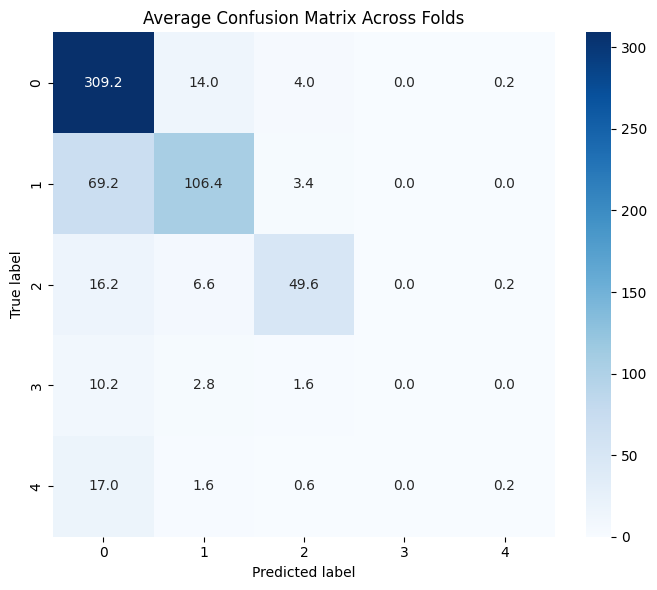


=== Summary ===
Dummy — Accuracy: 0.5341 ± 0.0008
Dummy — Balanced Accuracy: 0.2000 ± 0.0000
Dummy — F1 Score (macro): 0.1393 ± 0.0001
Dummy — Recall (macro): 0.2000 ± 0.0000


XGB — Accuracy: 0.7592 ± 0.0079
XGB — Balanced Accuracy: 0.4465 ± 0.0086
XGB — F1 Score (macro): 0.4567 ± 0.0121
XGB — Recall (macro): 0.4465 ± 0.0086

=== Final Averaged Classification Report Across All Folds ===
              precision    recall  f1-score   support

           0       0.73      0.94      0.83      1637
           1       0.81      0.59      0.69       895
           2       0.84      0.68      0.75       363
           3       0.00      0.00      0.00        73
           4       0.33      0.01      0.02        97

    accuracy                           0.76      3065
   macro avg       0.54      0.45      0.46      3065
weighted avg       0.74      0.76      0.73      3065



In [8]:
custom_metrics = {
    "Accuracy": accuracy_score,
    "Balanced Accuracy": balanced_accuracy_score,
    "F1 Score (macro)": lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'),
    "Recall (macro)": lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro')
}

fit_all_labels = xgb_cv(folds = folds, X = X, y = y, scoring_fns = custom_metrics)

# Reduced approach, excluding minority classes 3 (CGIN) & 4 (HPV INFECTION)

In [9]:
n_split = 5
shuffle = True
random_state = 42

data = np.load('combined_logmed_transformed.npz')
X = data['X']
y = data['y']

mask = (y != 3) & (y != 4)

# Apply mask to X and y
X_filtered = X[mask]
y_filtered = y[mask]

display(X_filtered)
print(Counter(y_filtered))
print(X_filtered.shape, y_filtered.shape)
print(np.unique(y_filtered))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds_red = []
for i, (train_idx_red, val_idx_red) in enumerate(skf.split(X_filtered, y_filtered)):
    folds_red.append({'fold': i+1, 'train_idx': train_idx_red, 'val_idx': val_idx_red})

array([[-0.00021589, -0.00021589, -0.00021589, ..., -0.00021589,
        -0.00021589, -0.00021589],
       [-0.00021602, -0.00021602, -0.00021602, ..., -0.00021602,
        -0.00021602, -0.00021602],
       [-0.00023529, -0.00023529, -0.00023529, ..., -0.00023529,
        -0.00023529, -0.00023529],
       ...,
       [-0.00026413, -0.00026413, -0.00026413, ..., -0.00018941,
        -0.00026413, -0.00026413],
       [-0.00026318, -0.00026318, -0.00026318, ..., -0.0001802 ,
        -0.00026318, -0.00026318],
       [-0.00025636, -0.00025636, -0.00025636, ..., -0.00025636,
        -0.00025636, -0.00025636]])

Counter({np.int64(0): 1637, np.int64(1): 895, np.int64(2): 363})
(2895, 2947) (2895,)
[0 1 2]


Algorithm initialising...


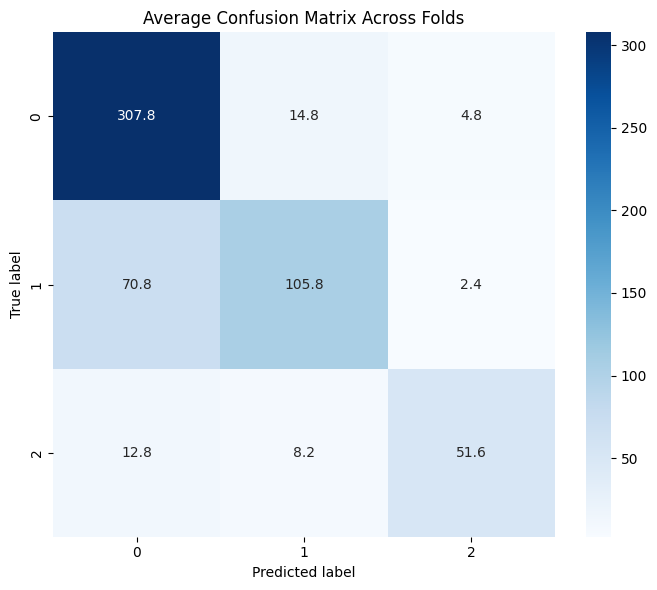


=== Summary ===
Dummy — Accuracy: 0.5655 ± 0.0008
Dummy — Balanced Accuracy: 0.3333 ± 0.0000
Dummy — F1 Score (macro): 0.2408 ± 0.0002
Dummy — Recall (macro): 0.3333 ± 0.0000


XGB — Accuracy: 0.8035 ± 0.0069
XGB — Balanced Accuracy: 0.7473 ± 0.0111
XGB — F1 Score (macro): 0.7763 ± 0.0104
XGB — Recall (macro): 0.7473 ± 0.0111

=== Final Averaged Classification Report Across All Folds ===
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1637
           1       0.82      0.59      0.69       895
           2       0.88      0.71      0.79       363

    accuracy                           0.80      2895
   macro avg       0.83      0.75      0.78      2895
weighted avg       0.81      0.80      0.80      2895



In [10]:
custom_metrics = {
    "Accuracy": accuracy_score,
    "Balanced Accuracy": balanced_accuracy_score,
    "F1 Score (macro)": lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'),
    "Recall (macro)": lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro')
}

fit_red_labels = xgb_cv(folds = folds_red, X = X_filtered, y = y_filtered, scoring_fns = custom_metrics)